## 사용 패키지

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor

from pycaret.regression import *

## 데이터 로드

In [3]:
train = pd.read_csv('C:/Users/user/Documents/dacon-fd/train.csv')
test = pd.read_csv('C:/Users/user/Documents/dacon-fd/test.csv')
submission = pd.read_csv('C:/Users/user/Documents/dacon-fd/sample_submission.csv')

## 데이터

## 요일을 숫자로 매핑

## `요일 랭크지정 방식.`
## 석식에만 적용! 석식 수요일이 자기개발의 날 때문에 적어서.

In [4]:
weekdayrankfordinner = {
    '월' : 1,
    '화' : 2,
    '수' : 5,
    '목' : 3,
    '금' : 4
} 

train['요일(석식)'] = train['요일'].map(weekdayrankfordinner)
test['요일(석식)'] = test['요일'].map(weekdayrankfordinner)

## `월, 일을 숫자형으로 변환`

In [5]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week
train['요일'] = train['일자'].dt.weekday


test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week
test['요일'] = test['일자'].dt.weekday

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


In [7]:
sampletrain = train.loc[:,('주','중식계','석식계')]
sampletrain.groupby(['주']).mean().iloc[:,0].sort_values()

주
52     672.571429
31     761.920000
33     793.000000
30     807.360000
32     822.200000
18     823.500000
46     824.040000
45     826.080000
47     826.120000
21     834.750000
44     847.080000
23     849.476190
51     857.320000
43     859.120000
28     859.600000
29     862.280000
42     863.720000
24     865.458333
17     873.400000
22     879.000000
26     879.700000
25     881.200000
27     881.217391
20     884.440000
15     889.750000
14     892.160000
16     893.375000
50     894.760000
19     897.095238
1      898.727273
3      910.960000
39     911.100000
36     911.520000
48     912.560000
2      913.680000
4      915.250000
37     916.250000
34     918.750000
13     921.400000
49     927.720000
35     933.760000
38     933.760000
12     954.360000
11     955.560000
6      966.157895
5      978.695652
9      983.190476
8      983.200000
10     984.000000
41     999.761905
7     1017.173913
40    1060.125000
Name: 중식계, dtype: float64

In [8]:
sampletrain.groupby(['주']).mean().iloc[:,1].sort_values()

주
52    216.952381
1     392.181818
31    399.000000
4     404.650000
48    404.840000
30    415.160000
26    417.550000
51    419.600000
43    422.800000
44    423.280000
46    426.720000
2     426.880000
17    430.520000
22    433.680000
33    434.285714
39    434.550000
29    434.800000
3     435.200000
32    437.640000
45    440.400000
18    441.937500
5     442.826087
47    443.480000
35    450.200000
23    457.333333
28    457.600000
37    458.850000
21    459.458333
19    464.523810
27    467.086957
24    470.083333
42    476.960000
9     479.428571
20    484.640000
38    484.680000
50    485.720000
25    490.350000
13    492.720000
16    494.666667
49    494.960000
12    505.040000
36    505.400000
15    508.000000
14    511.120000
34    512.958333
6     517.684211
11    539.120000
8     540.520000
7     541.391304
41    558.333333
10    577.240000
40    611.500000
Name: 석식계, dtype: float64

In [9]:
sampletrain = train.loc[:,('월','중식계','석식계')]
sampletrain.groupby(['월']).mean()

,중식계,석식계
월,,
1,934.247525,424.564356
2,989.623656,514.860215
3,953.607477,530.700935
4,883.621359,480.825243
5,869.787879,458.131313
6,863.311111,460.355556
7,848.736364,437.300000
8,854.785047,459.485981
9,907.148936,463.617021


In [10]:
expr = (train['년']>=2020) & (train['월'] >=1) & (train['월']<=4 )

In [11]:
train[expr].mean()

요일                   1.969697
본사정원수             2916.272727
본사휴가자수             141.030303
본사출장자수             194.181818
본사시간외근무명령서승인건수     347.727273
현본사소속재택근무자수        180.494949
중식계                931.979798
석식계                459.676768
요일(석식)               2.959596
년                 2020.171717
월                    2.252525
일                   15.464646
주                    8.373737
dtype: float64

## `월 랭크지정 방식` 낮은게 12 큰게 1 요일 랭크와 동일

In [12]:
month1 = {
    1:3,
    2:1,
    3:2,
    4:6,
    5:7,
    6:8,
    7:10,
    8:9,
    9:5,
    10:4,
    11:11,
    12:12
}

month2 = {
    1:11,
    2:2,
    3:1,
    4:4,
    5:8,
    6:6,
    7:9,
    8:7,
    9:5,
    10:3,
    11:10,
    12:12
}
train['월(중식)'] = train['월'].map(month1)
test['월(중식)'] = test['월'].map(month1)

train['월(석식)'] = train['월'].map(month2)
test['월(석식)'] = test['월'].map(month2)

train['월(중식)'] = train['월(중식)'].astype('int') # float형이라 int로 변경
test['월(중식)'] = test['월(중식)'].astype('int')
train['월(석식)'] = train['월(석식)'].astype('int')
test['월(석식)'] = test['월(석식)'].astype('int')

## `주 랭크지정 방식`


In [13]:
#중식
week1 = {
    52	:	52	,
    31	:	51	,
    33	:	50	,
    30	:	49	,
    32	:	48	,
    18	:	47	,
    46	:	46	,
    45	:	45	,
    47	:	44	,
    21	:	43	,
    44	:	42	,
    23	:	41	,
    51	:	40	,
    43	:	39	,
    28	:	38	,
    29	:	37	,
    42	:	36	,
    24	:	35	,
    17	:	34	,
    22	:	33	,
    26	:	32	,
    25	:	31	,
    27	:	30	,
    20	:	29	,
    15	:	28	,
    14	:	27	,
    16	:	26	,
    50	:	25	,
    19	:	24	,
    1	:	23	,
    3	:	22	,
    39	:	21	,
    36	:	20	,
    48	:	19	,
    2	:	18	,
    4	:	17	,
    37	:	16	,
    34	:	15	,
    13	:	14	,
    49	:	13	,
    35	:	12	,
    38	:	11	,
    12	:	10	,
    11	:	9	,
    6	:	8	,
    5	:	7	,
    9	:	6	,
    8	:	5	,
    10	:	4	,
    41	:	3	,
    7	:	2	,
    40	:	1	
}

#석식 위부터 작은수임

week2 = {
    52	:	52	,
    1	:	51	,
    31	:	50	,
    4	:	49	,
    48	:	48	,
    30	:	47	,
    26	:	46	,
    51	:	45	,
    43	:	44	,
    44	:	43	,
    46	:	42	,
    2	:	41	,
    17	:	40	,
    22	:	39	,
    33	:	38	,
    39	:	37	,
    29	:	36	,
    3	:	35	,
    32	:	34	,
    45	:	33	,
    18	:	32	,
    5	:	31	,
    47	:	30	,
    35	:	29	,
    23	:	28	,
    28	:	27	,
    37	:	26	,
    21	:	25	,
    19	:	24	,
    27	:	23	,
    24	:	22	,
    42	:	21	,
    9	:	20	,
    20	:	19	,
    38	:	18	,
    50	:	17	,
    25	:	16	,
    13	:	15	,
    16	:	14	,
    49	:	13	,
    12	:	12	,
    36	:	11	,
    15	:	10	,
    14	:	9	,
    34	:	8	,
    6	:	7	,
    11	:	6	,
    8	:	5	,
    7	:	4	,
    41	:	3	,
    10	:	2	,
    40	:	1	
}

train['주(중식)'] = train['주'].map(week1)
test['주(중식)'] = test['주'].map(week1)

train['주(석식)'] = train['주'].map(week2)
test['주(석식)'] = test['주'].map(week2)

train['주(중식)'] = train['주(중식)'].astype('int') # float형이라 int로 변경
test['주(중식)'] = test['주(중식)'].astype('int')
train['주(석식)'] = train['주(석식)'].astype('int')
test['주(석식)'] = test['주(석식)'].astype('int')

## `식사가능자수`

In [14]:
train['식사가능자수'] = (train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수'])
test['식사가능자수'] = (test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수'])

In [15]:
train['식사가능자수']

0       2551.0
1       2551.0
2       2545.0
3       2497.0
4       2323.0
         ...  
1200    2517.0
1201    2540.0
1202    2425.0
1203    2549.0
1204    2552.0
Name: 식사가능자수, Length: 1205, dtype: float64

# `0708 공휴일 전후 추가 `

In [16]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

In [17]:
#(공휴일+-1) = 1, (공휴일+-2) = 2, (휴가시즌 =3)
train['공휴일전후'][3] = 2 
train['공휴일전후'][4] = 1 
train['공휴일전후'][11] = 3 
train['공휴일전후'][17] = 1
train['공휴일전후'][18] = 1
train['공휴일전후'][47] = 1
train['공휴일전후'][48] = 1
train['공휴일전후'][62] = 1
train['공휴일전후'][67] = 1
train['공휴일전후'][82] = 1
train['공휴일전후'][83] = 1 
train['공휴일전후'][120:130] =3 # 휴가시즌
train['공휴일전후'][131] = 1
train['공휴일전후'][132] = 1
train['공휴일전후'][133] = 2
train['공휴일전후'][151] = 2
train['공휴일전후'][152] = 1
train['공휴일전후'][153] = 1 # 추석연휴 후월
train['공휴일전후'][163] = 1
train['공휴일전후'][221] = 2
train['공휴일전후'][226] = 3 # 20161230
train['공휴일전후'][245] = 1
train['공휴일전후'][246] = 1
train['공휴일전후'][266] = 1
train['공휴일전후'][268] = 2
train['공휴일전후'][267] = 1
train['공휴일전후'][308] = 2
train['공휴일전후'][309] = 1
train['공휴일전후'][310] = 1
train['공휴일전후'][311] = 1 #대선
train['공휴일전후'][330] = 1
train['공휴일전후'][331] = 1
train['공휴일전후'][367:378] = 3 #2017 여름휴가
train['공휴일전후'][379] = 1
train['공휴일전후'][380] = 1
train['공휴일전후'][381] = 2
train['공휴일전후'][413] = 1
train['공휴일전후'][467] = 1
train['공휴일전후'][469] = 2
train['공휴일전후'][470] = 3 # 2017 마지막
train['공휴일전후'][502] = 1
train['공휴일전후'][501] = 2
train['공휴일전후'][510] = 1
train['공휴일전후'][511] = 1
train['공휴일전후'][552] = 1
train['공휴일전후'][555] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][566] = 1
train['공휴일전후'][575] = 1
train['공휴일전후'][576] = 1
train['공휴일전후'][579] = 1 #지방선거전후
train['공휴일전후'][580] = 1
train['공휴일전후'][611:621] = 3 #휴가
train['공휴일전후'][622] = 2
train['공휴일전후'][623] = 1
train['공휴일전후'][624] = 1
train['공휴일전후'][625] = 2
train['공휴일전후'][651] = 1
train['공휴일전후'][705] = 1
train['공휴일전후'][706] = 1
train['공휴일전후'][707] = 3 #연말휴가
train['공휴일전후'][708] = 2
train['공휴일전후'][709] = 1 # 20181231
train['공휴일전후'][733] = 1
train['공휴일전후'][734] = 2
train['공휴일전후'][748] = 1
train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][814] = 1
train['공휴일전후'][850:861] = 3
train['공휴일전후'][862] = 2
train['공휴일전후'][863] = 1
train['공휴일전후'][864] = 1
train['공휴일전후'][882] = 1
train['공휴일전후'][898] = 1
train['공휴일전후'][899] = 2
train['공휴일전후'][897] = 1
train['공휴일전후'][904] = 3 #여기부터 패턴 금요일마다 휴가자 증가
train['공휴일전후'][909] = 3
train['공휴일전후'][924] = 3
train['공휴일전후'][929] = 3
train['공휴일전후'][939] = 3
train['공휴일전후'][949] = 3 #연말휴가
train['공휴일전후'][950] = 2
train['공휴일전후'][951] = 1
train['공휴일전후'][952] = 1
train['공휴일전후'][953] = 2
train['공휴일전후'][954] = 2
train['공휴일전후'][955] = 1
train['공휴일전후'][956] = 1
train['공휴일전후'][957] = 2
train['공휴일전후'][971] = 1
train['공휴일전후'][970] = 2
train['공휴일전후'][995] = 2
train['공휴일전후'][1020] = 3 #2020년코로나 변수 고려? 
train['공휴일전후'][1025] = 3
train['공휴일전후'][1029] = 3
train['공휴일전후'][1028] = 1 #국회의원선거
train['공휴일전후'][1027] = 1
train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1061] = 1
train['공휴일전후'][1084:1097] = 3
train['공휴일전후'][1098] = 2
train['공휴일전후'][1099] = 1
train['공휴일전후'][1100:1104] = 3
train['공휴일전후'][1108] = 3
train['공휴일전후'][1129] = 1
train['공휴일전후'][1128] = 2
train['공휴일전후'][1133] = 1
train['공휴일전후'][1058] = 3
train['공휴일전후'][1063] = 3
train['공휴일전후'][1068] = 3
train['공휴일전후'][1073] = 3
train['공휴일전후'][1078] = 3
train['공휴일전후'][1083] = 3
train['공휴일전후'][1187] = 1
train['공휴일전후'][1186] = 2

test['공휴일전후'][2] = 2 
test['공휴일전후'][10] = 1
test['공휴일전후'][11] = 2
test['공휴일전후'][20] = 1 
test['공휴일전후'][21] = 1
test['공휴일전후'][29] = 3
test['공휴일전후'][34] = 3
test['공휴일전후'][39] = 3
test['공휴일전후'][44] = 3
test['공휴일전후'][49] = 3

In [18]:
# 원핫인코딩
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [20]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,요일(석식),년,월,일,주,월(중식),월(석식),주(중식),주(석식),식사가능자수,공휴일전후_0,공휴일전후_1,공휴일전후_2,공휴일전후_3
0,2016-02-01,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,2016,2,1,5,1,2,7,31,2551.0,1,0,0,0
1,2016-02-02,1,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2016,2,2,5,1,2,7,31,2551.0,1,0,0,0
2,2016-02-03,2,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,5,2016,2,3,5,1,2,7,31,2545.0,1,0,0,0
3,2016-02-04,3,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,3,2016,2,4,5,1,2,7,31,2497.0,0,0,1,0
4,2016-02-05,4,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,4,2016,2,5,5,1,2,7,31,2323.0,0,1,0,0


## Feature

In [126]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수', '본사휴가자수', '주(중식)']] #중식계
x2_train = train[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','본사휴가자수','년','본사정원수']] #석식계

y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수', '본사휴가자수', '주(중식)']]
x2_test = test[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','본사휴가자수','년','본사정원수']]

# `Catboost + Kfold제출`

In [127]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

model1 = cat
model2 = cat

model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x1_test)

model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x2_test)

from sklearn.model_selection import KFold

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x1_test))    


model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x2_test))
    
pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

submission['중식계'] = pred1
submission['석식계'] = pred2

#submission.to_csv('catKfold+pca.csv', index=False)

Learning rate set to 0.040347
0:	learn: 203.8170163	total: 152ms	remaining: 2m 31s
1:	learn: 198.6827438	total: 155ms	remaining: 1m 17s
2:	learn: 193.7082029	total: 158ms	remaining: 52.6s
3:	learn: 188.9097369	total: 162ms	remaining: 40.4s
4:	learn: 184.5503014	total: 165ms	remaining: 32.9s
5:	learn: 180.0266580	total: 168ms	remaining: 27.9s
6:	learn: 175.7215082	total: 171ms	remaining: 24.2s
7:	learn: 171.8279960	total: 173ms	remaining: 21.4s
8:	learn: 168.2279498	total: 175ms	remaining: 19.2s
9:	learn: 164.4219195	total: 176ms	remaining: 17.4s
10:	learn: 161.0625857	total: 178ms	remaining: 16s
11:	learn: 157.5498769	total: 179ms	remaining: 14.7s
12:	learn: 154.3582953	total: 180ms	remaining: 13.7s
13:	learn: 151.4495556	total: 181ms	remaining: 12.8s
14:	learn: 148.4917296	total: 183ms	remaining: 12s
15:	learn: 145.6052617	total: 184ms	remaining: 11.3s
16:	learn: 142.9690415	total: 185ms	remaining: 10.7s
17:	learn: 140.3471500	total: 186ms	remaining: 10.2s
18:	learn: 138.0341117	total

# PCA

In [21]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '요일(석식)', '년', '월',
       '일', '주', '월(중식)', '월(석식)', '주(중식)', '주(석식)', '식사가능자수', '공휴일전후_0',
       '공휴일전후_1', '공휴일전후_2', '공휴일전후_3'],
      dtype='object')

In [22]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [23]:
train_pca_dn = train.drop(['조식메뉴','중식메뉴','석식메뉴','일자','월(중식)','주(중식)','중식계','월','주','요일'], axis=1) #석식계 pca
train_pca_ln = train.drop(['조식메뉴','중식메뉴','석식메뉴','일자','월(석식)','주(석식)','석식계','월','주','요일(석식)'], axis=1) #중식계

In [24]:
from sklearn.decomposition import PCA
from sklearn.linear_model import ridge, LogisticRegression

In [25]:
scale_dn = StandardScaler().fit_transform(train_pca_dn)
scale_ln = StandardScaler().fit_transform(train_pca_ln)

In [26]:
pca = PCA(n_components =8)

In [27]:
pca.fit(scale_dn)
train_dn = pca.transform(scale_dn)
print(train_dn.shape)

(1205, 8)


In [28]:
pca_columns = ['p_1','p_2','p_3','p_4','p_5','p_6','p_7','p_8'] #p_9','p_10'
trainDF_pca = pd.DataFrame(train_dn,columns=pca_columns)
trainDF_pca['target']= train_pca_dn.석식계

In [29]:
trainDF_pca

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,target
0,-0.655117,-0.071794,2.135400,-0.047998,-0.729934,-0.572668,-0.042229,0.835619,331.0
1,-1.207152,-0.023931,2.371072,0.068515,-0.389397,-0.698371,-0.204156,0.856250,560.0
2,-0.801126,-1.300819,1.580342,0.906439,-0.695655,-0.988647,-0.443065,1.081282,573.0
3,1.300571,-0.670251,2.442480,0.493699,2.909039,3.600124,-2.791567,4.733849,525.0
4,3.280695,-1.405445,3.192014,1.886194,-0.877508,0.735930,2.311094,0.130776,330.0
...,...,...,...,...,...,...,...,...,...
1200,1.196312,1.382347,-2.714414,0.464964,-2.731067,-0.321699,-1.049416,0.605721,421.0
1201,0.640411,2.297263,-2.319882,-0.432647,-1.976971,0.096617,-0.612710,0.096625,353.0
1202,2.029936,0.635760,-2.889824,0.137288,-2.286341,0.013204,-0.663864,0.054596,217.0
1203,0.547889,3.866868,-1.131515,-1.809383,-2.058487,0.495307,-0.721599,-0.161510,502.0


In [30]:
pca.explained_variance_ratio_

array([0.21134839, 0.16087541, 0.14448166, 0.09477727, 0.07534043,
       0.06714201, 0.06165439, 0.06110955])

In [31]:
sum(pca.explained_variance_ratio_)

0.8767291004583699

In [31]:
#y_target = train_pca_dn['석식계']
#scores_pca_dn = cross_val_score(cat,train_dn, y_target,scoring='', cv=3)

In [32]:
abs(train_pca_ln.corr()['중식계']).sort_values()

현본사소속재택근무자수       0.076509
년                 0.078804
일                 0.097392
본사정원수             0.115529
공휴일전후_2           0.117056
공휴일전후_1           0.118765
식사가능자수            0.151029
공휴일전후_3           0.174600
월(중식)             0.218376
공휴일전후_0           0.249245
주(중식)             0.285160
본사휴가자수            0.391975
본사출장자수            0.512680
본사시간외근무명령서승인건수    0.535611
요일                0.734273
중식계               1.000000
Name: 중식계, dtype: float64

In [33]:
abs(train_pca_dn.corr()['석식계']).sort_values()

현본사소속재택근무자수       0.057534
공휴일전후_2           0.076105
식사가능자수            0.118615
공휴일전후_3           0.122286
공휴일전후_1           0.153929
본사정원수             0.173852
일                 0.185565
본사출장자수            0.188164
년                 0.194792
공휴일전후_0           0.218995
월(석식)             0.245495
본사휴가자수            0.316894
주(석식)             0.356084
요일(석식)            0.472469
본사시간외근무명령서승인건수    0.571168
석식계               1.000000
Name: 석식계, dtype: float64

<AxesSubplot:>

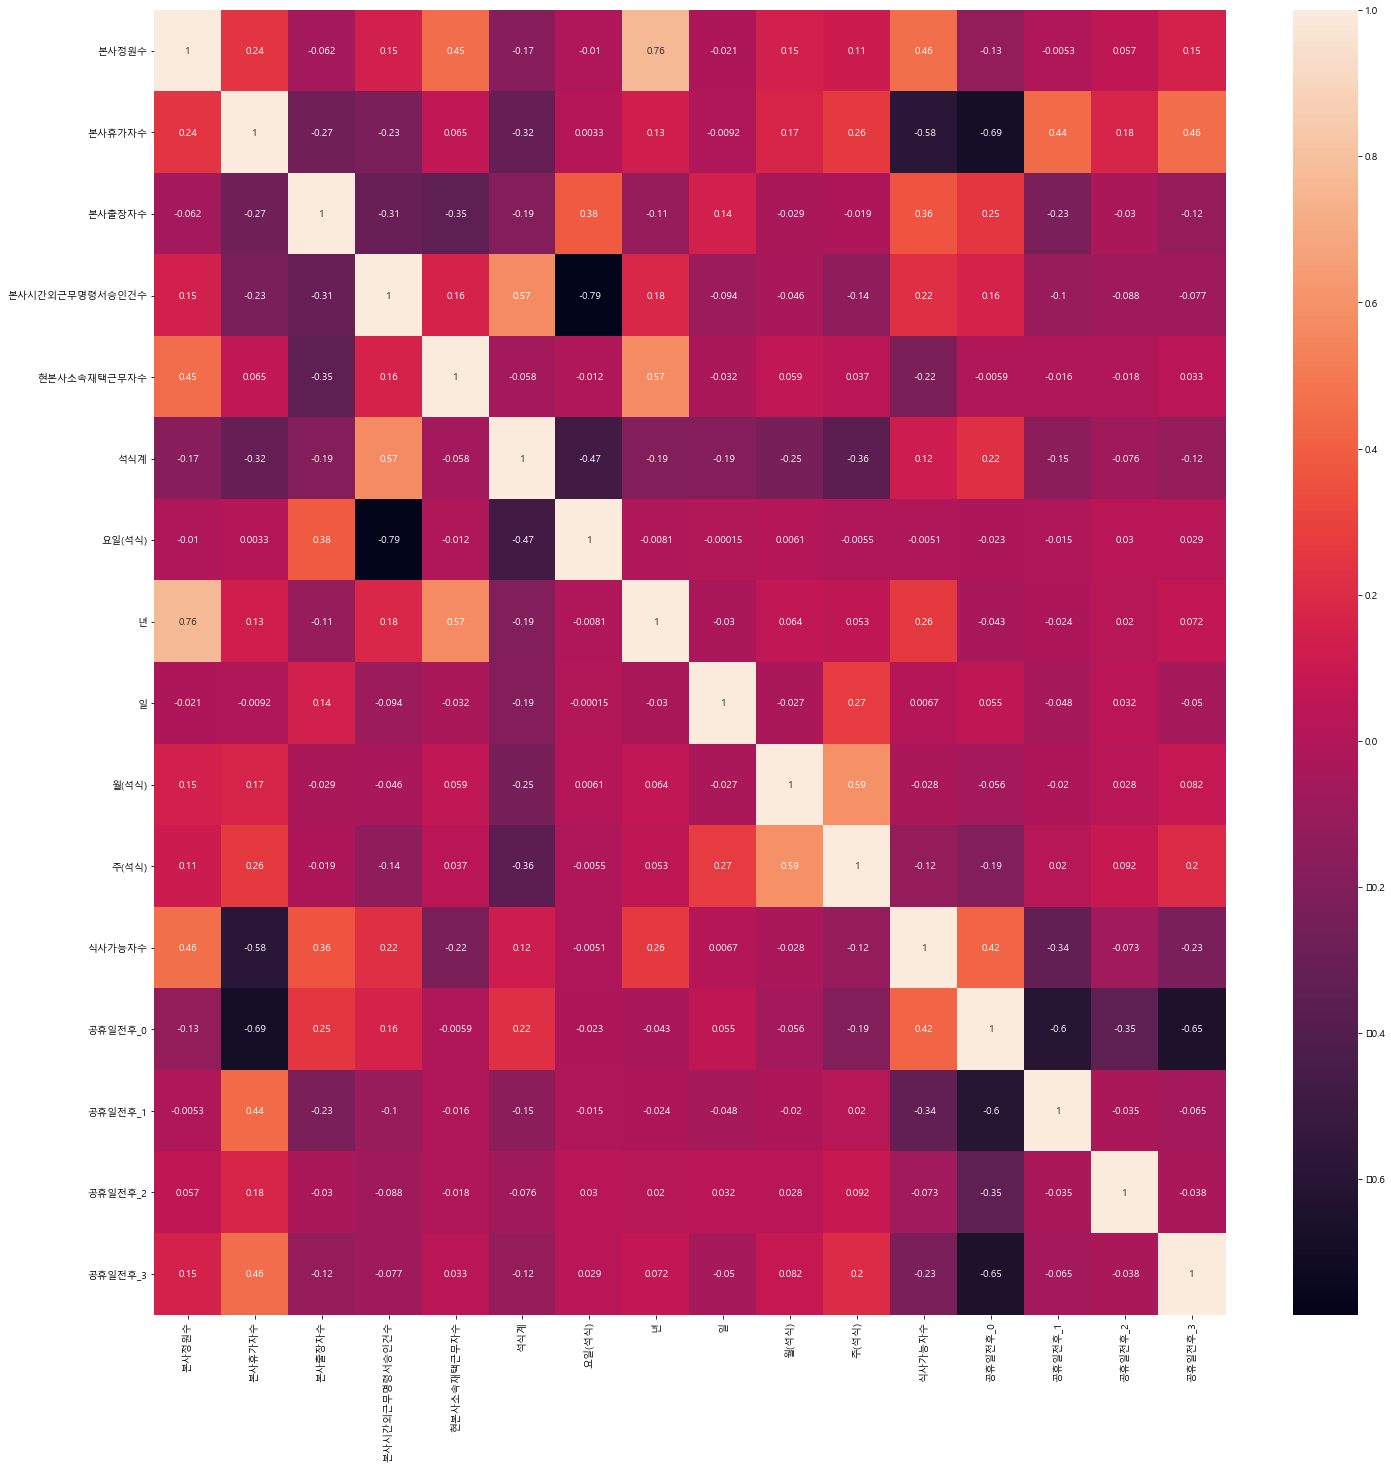

In [34]:
corr = train_pca_dn.corr()
plt.figure(figsize=(24,24))
sns.heatmap(corr, annot=True)

In [35]:
pca_ln = PCA(n_components =8)

In [36]:
pca_ln.fit(scale_ln)
train_ln = pca_ln.transform(scale_ln)
print(train_ln.shape)

(1205, 8)


In [37]:
train_pca_ln.중식계

0       1039.0
1        867.0
2       1017.0
3        978.0
4        925.0
         ...  
1200    1093.0
1201     832.0
1202     579.0
1203    1145.0
1204    1015.0
Name: 중식계, Length: 1205, dtype: float64

In [38]:
pca_columns = ['p_1','p_2','p_3','p_4','p_5','p_6','p_7','p_8'] #'p_8','p_9','p_10'
trainDF_pca_ln = pd.DataFrame(train_ln,columns=pca_columns)
trainDF_pca_ln['target']= train_pca_ln.중식계

In [39]:
trainDF_pca_ln

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,target
0,-1.892578,0.771452,2.858817,1.009317,0.002573,-1.183381,-1.001118,0.523086,1039.0
1,-1.551861,0.096965,2.343220,1.207763,-0.065179,-1.235235,-0.959632,0.512351,867.0
2,-1.402419,-0.313125,2.313665,1.495749,-0.229425,-1.198782,-1.103740,0.462746,1017.0
3,0.949808,-0.067491,2.279213,2.471614,4.749394,1.798913,-3.726671,3.517031,978.0
4,2.472184,0.294757,3.654543,3.565703,0.300821,-1.518574,1.669533,0.587212,925.0
...,...,...,...,...,...,...,...,...,...
1200,-0.598413,2.230924,-1.657344,1.801279,-2.005043,1.161846,-0.775595,-0.090392,1093.0
1201,-0.494295,1.722463,-2.257432,1.649757,-1.654218,0.934955,-0.518781,-0.156083,832.0
1202,1.206795,0.305019,-2.507126,2.446581,-2.040329,1.000141,-0.529685,-0.231246,579.0
1203,-1.657298,3.953880,-0.832407,0.994695,-1.156155,1.541164,-0.366269,-0.656815,1145.0


In [40]:
pca_ln.explained_variance_ratio_

array([0.22039536, 0.16941733, 0.14085849, 0.09823839, 0.06997473,
       0.06511472, 0.06114812, 0.05862671])

In [41]:
sum(pca_ln.explained_variance_ratio_)

0.8837738444088951

<AxesSubplot:>

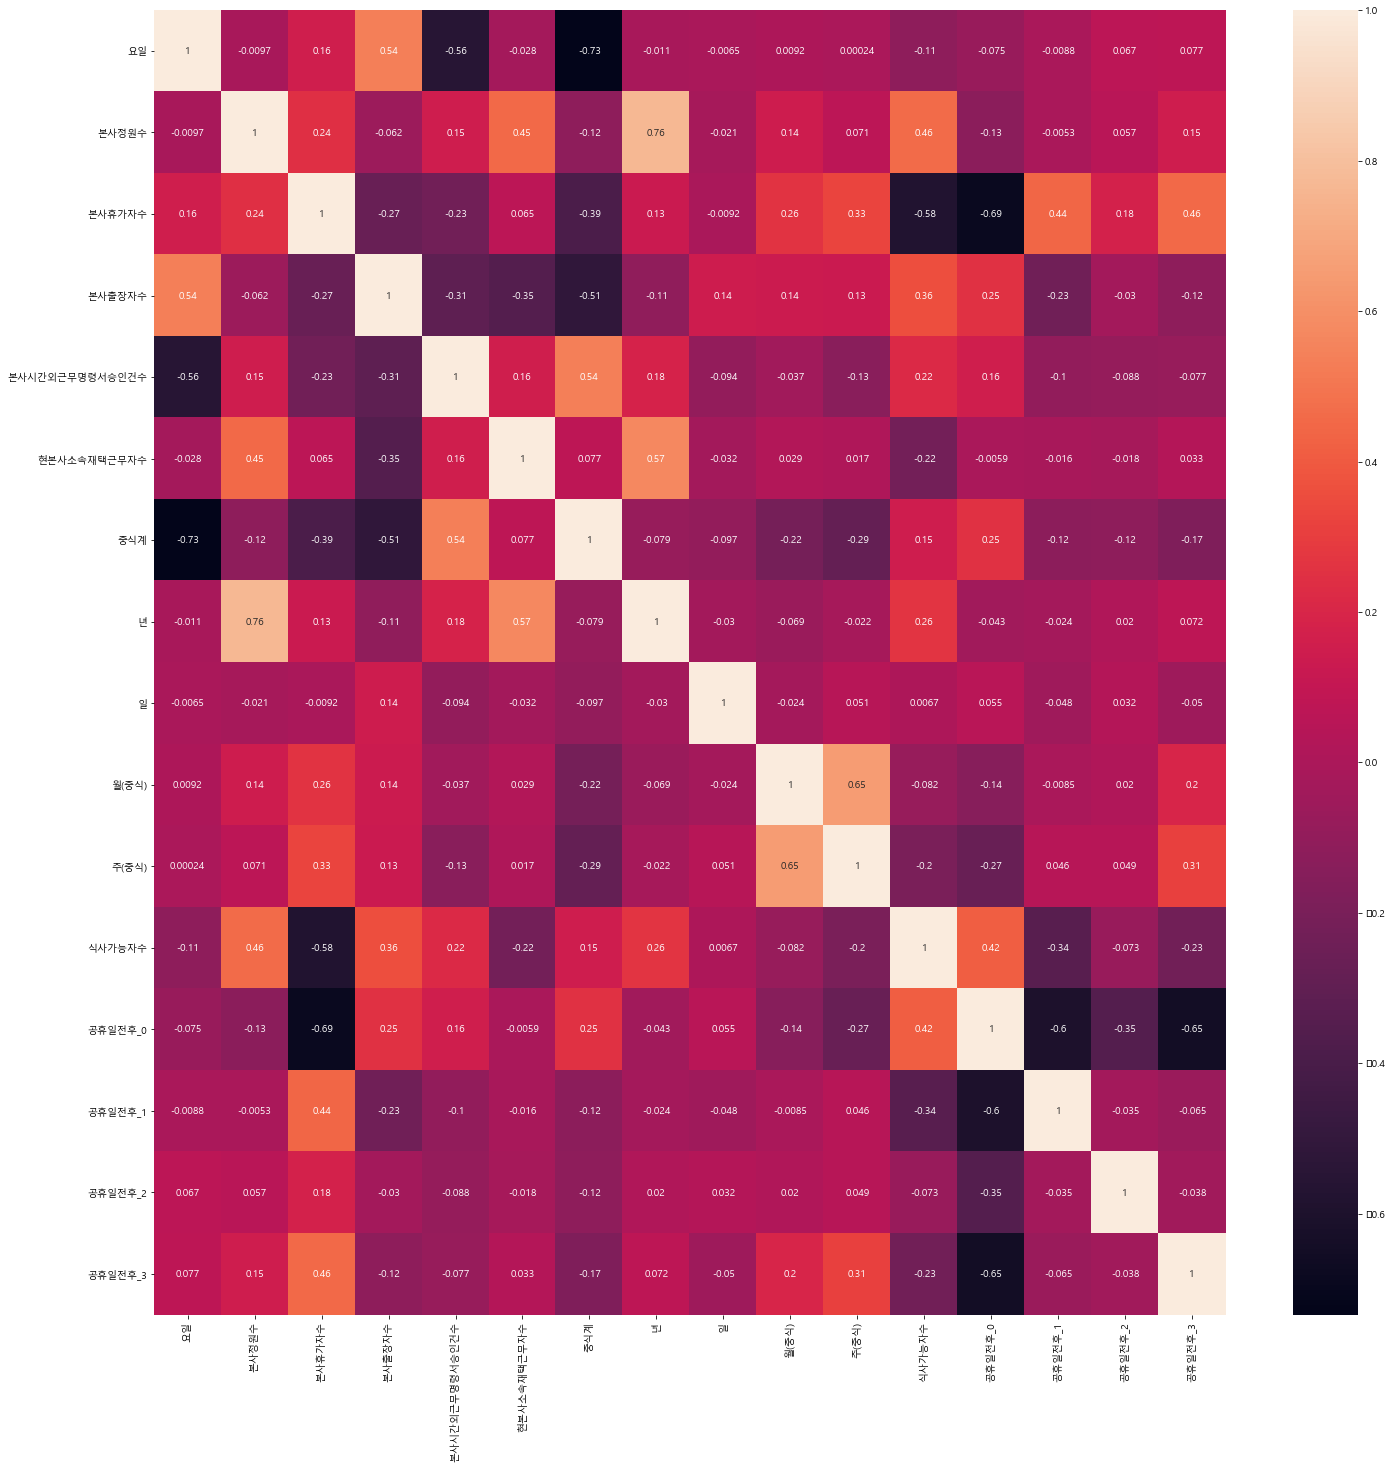

In [42]:
corr = train_pca_ln.corr()
plt.figure(figsize=(24,24))
sns.heatmap(corr, annot=True)

# `커널 PCA`

In [173]:
from sklearn.decomposition import KernelPCA
import numpy as np

In [209]:
kpca = KernelPCA(n_components= 9, kernel = 'rbf', gamma =15)

In [210]:
train_kpca = kpca.fit_transform(train_pca_dn)
y = train_pca_dn.석식계

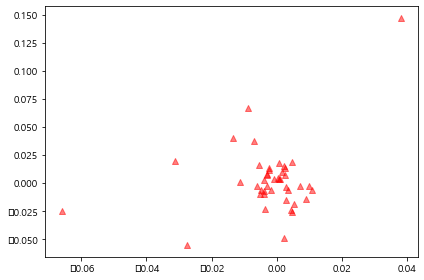

In [211]:
plt.scatter(train_kpca[y==0,0], train_kpca[y==0,1],
           color='red', marker='^', alpha=0.5)
plt.scatter(train_kpca[y==1,0], train_kpca[y==1,1],
           color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

In [177]:
train_kpca.shape

(1205, 9)

In [205]:
train_pca_dn.shape

(1205, 16)

In [178]:
trainDF_kpca = pd.DataFrame(train_kpca)
trainDF_kpca['target']= train_pca_dn.석식계

In [179]:
trainDF_kpca

,0,1,2,3,4,5,6,7,8,target
0,-0.001225,-0.066667,0.007251,0.005888,-0.007645,0.014235,0.031571,0.005343,-0.063599,331.0
1,0.036256,0.029854,0.043116,-0.006401,-0.009004,0.002235,-0.039498,-0.030054,-0.004164,560.0
2,0.011894,-0.000776,-0.033103,0.033990,0.002683,-0.062655,0.030744,0.009579,0.005649,573.0
3,-0.053260,0.005893,-0.006162,-0.012903,-0.006629,0.006472,-0.002952,-0.003691,0.006895,525.0
4,0.003509,-0.008438,0.013236,-0.007637,0.013969,-0.025019,0.011305,-0.009766,-0.000294,330.0
...,...,...,...,...,...,...,...,...,...,...
1200,0.001221,0.011156,0.003023,-0.002119,-0.004339,-0.002790,0.000005,-0.003837,-0.021164,421.0
1201,0.000285,0.003266,-0.003266,-0.000821,0.005485,-0.001581,-0.008521,0.000950,0.025419,353.0
1202,0.000201,0.002255,-0.003679,-0.000846,0.005495,-0.002257,-0.008732,0.000645,0.023281,217.0
1203,0.000334,0.004387,0.001886,-0.001644,-0.000296,-0.002980,-0.003117,-0.002621,-0.000821,502.0


In [169]:
explained_variance = np.var(train_kpca, axis=0)
explained_variance

array([0.00082988, 0.00082988, 0.00082988, 0.00082988, 0.00082988,
       0.00082988, 0.00082988, 0.00082988, 0.00082988])

In [170]:
explained_variance_ratio = explained_variance / np.sum(explained_variance)

In [171]:
explained_variance_ratio

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [172]:
np.cumsum(explained_variance_ratio)

array([0.11111111, 0.22222222, 0.33333333, 0.44444444, 0.55555556,
       0.66666667, 0.77777778, 0.88888889, 1.        ])

# `LLE`

In [181]:
from sklearn.manifold import LocallyLinearEmbedding

In [184]:
lle = LocallyLinearEmbedding(n_neighbors= 7, n_components=2, random_state=42)

In [185]:
lle_dn = lle.fit(train_pca_dn)

In [186]:
#LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
#            method='standard', modified_tol=1e-12, n_components=2,
#            n_jobs=1, n_neighbors=10, neighbors_algorithm='auto',
#            random_state=42, reg=0.001, tol=1e-06)

LocallyLinearEmbedding(n_jobs=1, n_neighbors=10, random_state=42)

In [194]:
y = lle_dn.fit_transform

In [204]:
n_data_per_class = 50
n_classes = 3

x = []
y = []
for c in range(n_classes):
    x_ = 0.3 * np.random.random_sample((n_data_per_class, 2))
    x_ += np.random.random_sample((1, 2))
    x.append(x_)
    y.append(np.asarray([c] * n_data_per_class))
x = np.vstack(x)
y = np.concatenate(y)

In [203]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import export_png

output_notebook()

title = '{} classes {} points'.format(n_classes, n_classes * n_data_per_class)

def draw_figure(x, y, title, show_figure=True,
    colors = 'firebrick darksalmon lightseagreen'.split()):

    p = figure(width=400, height=400, title=title)
    for c in range(n_classes):
        idx = np.where(y == c)[0]
        x_ = x[idx]
        p.scatter(x_[:,0], x_[:,1], fill_color=colors[c], line_color=colors[c])
    if show_figure:
        show(p)
    return p

p = draw_figure(x, y, title)

Loading BokehJS ...